In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
xs=pd.read_csv('ChickenOTUs.txt', sep="\t", index_col=0)
metx=pd.read_csv('Chicken.log10MetabsCtrlNar+0.txt', sep="\t", index_col=0)

#replace NaNs with median 
for i in metx.columns:
    med=metx[i].median()
    metx.loc[:,i]=metx.loc[:,i].fillna(med)

In [3]:
#zscore metadata
nSamp, nMet = metx.shape
nD=xs.shape[1]

In [4]:
def train_tmi(xs, metz, nQ, nC, nM, alph, ctf):
    nSamp, nO = xs.shape;
    nMet = metz.shape[1];
    nTot                = nQ + nC + nM;
    Z                   = 0.1*np.random.randn(nSamp,nTot);
    C                   = 0.1*np.random.randn(nTot,nMet);
    C[0:nQ,:]           = 0;
    thet                = 0.1*np.random.randn(nTot,nO);
    thet[nQ+nC:,:]      = 0;
    thetp               = thet.transpose();
    # hyperparameters
    etaZ = 0.001;etaT = 0.001;etaC = 0.001;
    Q = np.exp(np.matmul(-Z,thet));
    Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
    m = 1;
    iteration = 1;
    while m > ctf:
        Q = np.exp(np.matmul(-Z,thet));
        Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
        delt = xs.values-Q;
        # gradients
        grthet           = (alph)*np.matmul(Z.transpose(),delt);
        grthet[nQ+nC:,:] = 0;
        grzQ             = (alph)*np.matmul(delt,thetp);
        grzM             = -2*(1-alph)*np.matmul((metz.values-np.matmul(Z,C)),C.transpose());
        grz              = grzQ + grzM
        grc              = -2*(1-alph)*np.matmul(Z.transpose(),(metz.values - np.matmul(Z,C)))
        grc[0:nQ,:]      = 0;
        # update the variables
        Z     = Z - etaZ*grz
        thet  = thet - etaT*grthet
        C     = C - etaC*grc
        thetp = thet.transpose();
        
        # errors
        dmet=np.matmul(Z,C)-metz.values
        kl=np.nansum(xs.values*np.log(xs.values/Q))
        er=(dmet*dmet).sum()
        error=(1-alph)*kl + alph*er
        #m = np.min(np.min(Q));
        m=np.linalg.norm(grz)/np.linalg.norm(Z) + np.linalg.norm(grthet)/np.linalg.norm(thet)+np.linalg.norm(grc)/np.linalg.norm(C)
        # Output
        if np.mod(iteration,5000) == 0:
            print(m)
        iteration+=1
        
    return Z, C, thet, error

In [5]:
seed=123
np.random.seed(seed)

In [6]:
# optimization parameters
nQ = 2;nC = 18;nM = 0;
ctf  = 1e-20; 
alph = 0.1; 
gctf = 0.01;

In [7]:
#split dataset
N=int(nSamp*.2)
order=np.random.permutation(xs.index)
testids=order[0:N]
testids=xs.index[xs.index.isin(xs.index[15:30])] ###### For predicting avilamycin 

test=xs.loc[testids]
train=xs.loc[~xs.index.isin(testids)]
testmet=metx.loc[testids]
trainmet=metx.loc[~xs.index.isin(testids)]
N=len(train.index)

In [8]:
mu_met = trainmet.mean();sg_met = trainmet.std();
trainmetz=trainmet.subtract(mu_met).divide(sg_met)
testmetz=testmet.subtract(mu_met).divide(sg_met)

In [9]:
# Train model
Z, C, thet, error= train_tmi(train,trainmetz,nQ,nC,nM,alph,gctf);

/tmp/ipykernel_11937/3940590118.py:37: RuntimeWarning: divide by zero encountered in log
  kl=np.nansum(xs.values*np.log(xs.values/Q))
/tmp/ipykernel_11937/3940590118.py:37: RuntimeWarning: invalid value encountered in multiply
  kl=np.nansum(xs.values*np.log(xs.values/Q))


0.08351538497326141
0.05231244326929076
0.03762062995493525
0.029546374980178286
0.024832627876360026
0.022167665075562167
0.020972328624833902
0.02098900461597094
0.02196542807475451
0.02337633139584265
0.024266410969282864
0.023428416860328174
0.020493901046572748
0.016999850198557407
0.014592773124184857
0.012947860862361726
0.01161469128182836
0.010477700506892538


In [10]:
model={}
Q=np.exp(np.matmul(-Z,thet));
Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
model['Z']=Z
model['thet']=thet
model['Q']=Q
model['xs']=train
model['C']=C
model['metz']=trainmetz
model['alph']=alph
model['nQ']=nQ
model['nC']=nC
model['nM']=nM
model['nD']=nD
model['seed']=seed
model['error']=error
model['test']=test
model['testmetz']=testmetz

In [11]:
filen = 'Avilamycin_'+str(nC)+'_'+str(nQ)+'_'+str(nM)+'_'+str(seed)+'_'+f'{error:.3}'+'.pickle'
filen

'Avilamycin_18_2_0_123_1.34e+02.pickle'

In [12]:
with open(filen,'wb') as f:
        pickle.dump(model,f)

In [13]:
filen='Avilamycin_18_2_0_123_1.34e+02.pickle'


In [14]:
with open(filen,'rb') as f:
        model=pickle.load(f)
Z=model['Z']
thet=model['thet']
Q=model['Q']
train=model['xs']
C=model['C']
trainmetz=model['metz']
alph=model['alph']
nQ=model['nQ']
nC=model['nC']
nM=model['nM']
nD=model['nD']
seed=model['seed']
error=model['error']
test=model['test']
testmetz=model['testmetz']

In [15]:
def predict_microbiome_pd(model, testmetz):
    nTest=len(testmetz.index)
    nQ=model['nQ']
    nC=model['nC']
    Cplus=np.linalg.pinv(model['C'])
    muZ=model['Z'].mean(axis=0)
    covZ=np.cov(model['Z'].transpose())
    cov11=covZ[0:nQ,0:nQ]
    cov12=covZ[0:nQ,nQ:]
    cov21=cov12.transpose()
    cov22=covZ[nQ:,nQ:]
    
    prd = np.zeros((nTest,model['xs'].shape[1]))
    for i in range(nTest):
        Zp1 = np.matmul(testmetz.values[i,:],Cplus) 
        Zp1 = Zp1[nQ:]
        mubar = muZ[0:nQ] + np.matmul(np.matmul(cov12,np.linalg.inv(cov22)),Zp1.transpose()-muZ[nQ:]);
        Zpx = np.concatenate((mubar.transpose(), Zp1), axis=0)
        f = np.matmul(Zpx,model['thet'])
        Q = np.exp(-f)
        Q = Q/Q.sum()
        prd[i,:] = Q;

    return prd

In [16]:
#evaluate model fit
prd=predict_microbiome_pd(model,trainmetz)

In [17]:
corrs=[]
for i in range(len(train.index)):
    r,p=stats.spearmanr(prd[i,:],train.loc[train.index[i],:])
    if np.isnan(r):
        continue
    corrs.append(r)
order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]


#use random pairs in training as null

order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullspear=[]
nullspearp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(train.loc[hf1[i],:],train.loc[hf2[i],:])
    nullspear.append(r)
    nullspearp.append(p)
s,p=stats.mannwhitneyu(corrs,nullspear,alternative='greater')

In [18]:
profile=corrs
random=nullspear

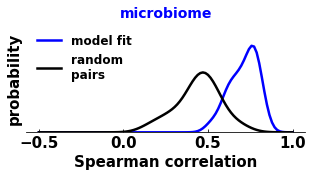

In [19]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(profile)
x = np.linspace(np.min(profile+[-0.5]), np.max(profile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='b',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(random)
x = np.linspace(np.min(random+[-0.5]), np.max(random+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,5.7)
ax.set_title('microbiome', fontweight='bold', fontsize=14, color='b')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False)
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');

In [20]:
#Accuracy for each OTU (training data)
corrotu=[]
for i in range(len(train.columns)):
    r,p=stats.spearmanr(prd[:,i],train.loc[:,train.columns[i]])
    if np.isnan(r):
        continue
    corrotu.append(r)
    

/home/platyias/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [21]:
order=np.random.permutation(train.columns)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullotu=[]
nullotup=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(train.loc[:,hf1[i]],train.loc[:,hf2[i]])
    if np.isnan(r):
        continue
    nullotu.append(r)
    nullotup.append(p)

In [22]:
corrotu_pred=corrotu

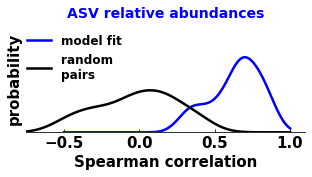

In [23]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(corrotu)
x = np.linspace(np.min(corrotu+[-0.5]), np.max(corrotu+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='b',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(nullotu)
x = np.linspace(np.min(nullotu+[-0.75]), np.max(nullotu+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,3.5)
ax.set_xlim(-0.75,1.1)
ax.set_title('ASV relative abundances', fontweight='bold', fontsize=14, color='b')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.38,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');

In [24]:
def predict_metadata_pd(model,test):
    nTest=len(test.index)
    nQ=model['nQ']
    nC=model['nC']
    ths=model['thet'][0:nQ+nC,:]
    Ztest = 0.1*np.random.randn(nTest,nC+nQ);
    eta = 0.005;
    for i in range(10000):
        f=np.matmul(Ztest,ths)
        Q=np.exp(-f)
        Q  = np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
        delt=test.values-Q
        grz=np.matmul(delt,ths.transpose())
        Ztest=Ztest-eta*grz
    muZ=model['Z'].mean(axis=0)
    covZ=np.cov(Z.transpose())
    cov11=covZ[nQ+nC:,nQ+nC:]
    cov12=covZ[nQ+nC:,0:nQ+nC]
    cov21=cov12.transpose()
    cov22=covZ[0:nQ+nC,0:nQ+nC]
    prd=np.zeros((nTest,model['metz'].shape[1]))
    for i in range(nTest):
        Zp1 = Ztest[i,:]
        mubar = muZ[nQ+nC:] + np.matmul(np.matmul(cov12,np.linalg.inv(cov22)),Zp1.transpose()-muZ[0:nQ+nC])
        Zpx = np.concatenate((Zp1,mubar.transpose()), axis=0)
        f = np.matmul(Zpx,model['C'])        
        prd[i,:] = f;   
    return prd

In [25]:
prddf=pd.DataFrame(index=testmetz.index,columns=testmetz.columns, data=predict_metadata_pd(model,test))

In [26]:
prddftrain=pd.DataFrame(index=trainmetz.index,columns=trainmetz.columns, data=predict_metadata_pd(model,train))

In [27]:
#Accuracy across metabolites (Z-normalized) trainig data
spear=[]
spearp=[]
for i in range(len(test.index)):
    r,p = stats.spearmanr(prddftrain.values[i,:],trainmetz.values[i,:])
    if np.isnan(r):
        continue
    spear.append(r)
    spearp.append(p)
    
#use random pairs in training as null
order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullspear=[]
nullspearp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(trainmetz.loc[hf1[i],:],trainmetz.loc[hf2[i],:])
    nullspear.append(r)
    nullspearp.append(p)
s,p=stats.mannwhitneyu(spear,nullspear,alternative='greater')


In [28]:
mettrain=spear
randommet=nullspear

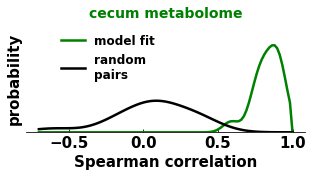

In [29]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(mettrain)
x = np.linspace(np.min(mettrain+[-0.7]), np.max(mettrain+[1]), 100)
y=kde(x)
y[-1]=0
ax=sns.lineplot(x=x, y=y,color='g',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(randommet)
x = np.linspace(np.min(randommet+[-0.7]), np.max(randommet+[1]), 100)

ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,5)
ax.set_title('cecum metabolome', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.5,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15, direction='in')
plt.xticks(weight = 'bold');

In [30]:
#Accuracy for each metadata variable training data
corrmet=pd.DataFrame(index=model['metz'].columns, columns=['r','p'])
for i in model['metz'].columns:
    r,p=stats.spearmanr(prddftrain.loc[:,i],trainmetz.loc[:,i])
    corrmet.loc[i,:]=[r,p]

corrmettrain=list(corrmet.r.values)

order=np.random.permutation(trainmetz.columns)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullmet=[]
nullmetp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(trainmetz.loc[:,hf1[i]],trainmetz.loc[:,hf2[i]])
    if np.isnan(r):
        continue
    nullmet.append(r)
    nullmetp.append(p)

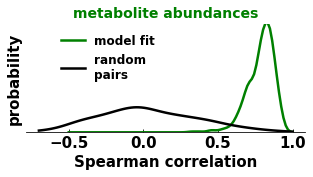

In [31]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(corrmettrain)
x = np.linspace(np.min(corrmettrain+[-0.5]), np.max(corrmettrain+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='g',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(nullmet)
x = np.linspace(np.min(nullmet+[-0.7]), np.max(nullmet+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,5.2)
ax.set_title('metabolite abundances', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.5,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');

In [32]:
#Accuracy across metabolites (Z-normalized)
spear=[]
spearp=[]
for i in range(len(test.index)):
    r,p = stats.spearmanr(prddf.values[i,:],testmetz.values[i,:])
    if np.isnan(r):
        continue
    spear.append(r)
    spearp.append(p)
    
#use random pairs in training as null
n=10
pvals=[]
for i in range(n):
    order=np.random.permutation(train.index)
    hf1=order[0:int(len(order)/2)]
    hf2=order[int(len(order)/2):]
    nullspear=[]
    nullspearp=[]
    for i in range(len(hf1)):
        r,p = stats.spearmanr(trainmetz.loc[hf1[i],:],trainmetz.loc[hf2[i],:])
        nullspear.append(r)
        nullspearp.append(p)
    s,p=stats.mannwhitneyu(spear,nullspear,alternative='greater')
    pvals.append(p)
p=np.median(pvals)

In [33]:
randommet=nullspear

In [34]:
prd_metprofile=spear

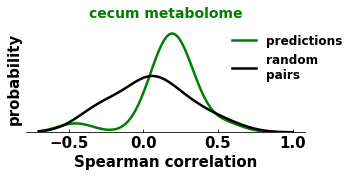

In [35]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(prd_metprofile)
x = np.linspace(np.min(prd_metprofile+[-0.7]), np.max(prd_metprofile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='g',linewidth=2.5,linestyle='-', label='predictions')

kde=stats.gaussian_kde(randommet)
x = np.linspace(np.min(randommet+[-0.7]), np.max(randommet+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,2.7)
ax.set_title('cecum metabolome', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.7,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15, direction='in')
plt.xticks(weight = 'bold');

In [36]:
#Accuracy for each metadata variable
corrmet=pd.DataFrame(index=model['metz'].columns, columns=['r','p'])
for i in model['metz'].columns:
    r,p=stats.spearmanr(prddf.loc[:,i],testmetz.loc[:,i])
    corrmet.loc[i,:]=[r,p]

corrmetr=list(corrmet.r.values)

In [37]:
order=np.random.permutation(trainmetz.columns)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullmet=[]
nullmetp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(trainmetz.loc[:,hf1[i]],trainmetz.loc[:,hf2[i]])
    if np.isnan(r):
        continue
    nullmet.append(r)
    nullmetp.append(p)

In [38]:
corrmet_pred=list(corrmet.r.values)

In [39]:
corrmet_pred=list(corrmet_pred)

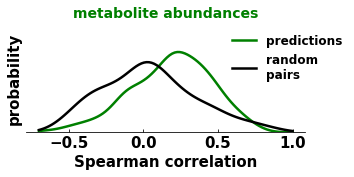

In [40]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(corrmet_pred)
x = np.linspace(np.min(corrmet_pred+[-0.7]), np.max(corrmet_pred+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='g',linewidth=2.5,linestyle='-', label='predictions')

kde=stats.gaussian_kde(nullmet)
x = np.linspace(np.min(nullmet+[-0.7]), np.max(nullmet+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,2)
ax.set_title('metabolite abundances', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.7,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');

In [41]:
pd.set_option('display.max_rows', 1000)

In [42]:
#Fraction positive correlations
(corrmet.r>0).sum()/len(corrmet)

0.7610062893081762

In [43]:
#Number significant correlations
len(corrmet[(corrmet.r>0)&(corrmet.p<0.05)])/len(corrmet)

0.10272536687631027

In [44]:
corrmet[(corrmet.r>0)&(corrmet.p<0.05)].r.min()

0.5142857142857142

In [47]:
corrmet.loc[:,'sig']=0
corrmet.loc[corrmet.index[(corrmet.r>0)&(corrmet.p<0.05)],'sig']=1

In [48]:
corrmet=corrmet.sort_values('r')
corrmet.loc[:,'rank']=range(len(corrmet))

In [49]:
#compare sign of predicted and measured changes vs control
prddfraw=prddf.multiply(sg_met).add(mu_met)
sign=pd.DataFrame(index=prddf.columns, columns=['measured','predicted','tp'])
for i in prddf.columns:
    sign.loc[i,'measured']=1/(trainmet.loc[xs.index[0:15],i].mean()/testmet[i].mean())
    sign.loc[i,'predicted']=1/(trainmet.loc[xs.index[0:15],i].mean()/prddfraw[i].mean())

In [50]:
sign.loc[:,'tp']=0
for i in sign.index:
    if (sign.loc[i,'measured']>1)&(sign.loc[i,'predicted']>1):
        sign.loc[i,'tp']=1
    if (sign.loc[i,'measured']<1)&(sign.loc[i,'predicted']<1):
        sign.loc[i,'tp']=1

SpearmanrResult(correlation=0.49290266355219753, pvalue=1.4437149533813563e-30)

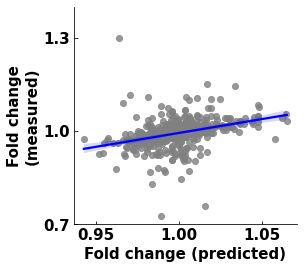

In [51]:
#ax=sns.scatterplot(x=np.log2(sign.measured.astype(float)), y=np.log2(sign.predicted.astype(float)), s=50, color='k')
fig,ax=plt.subplots(figsize=(4,4))
ax=sns.regplot(y=sign.measured.astype(float), x=sign.predicted.astype(float), color='gray', line_kws={"color": "blue"})
ax.set_xlabel('Fold change (predicted)', fontsize=15, fontweight='bold')
ax.set_ylabel('Fold change\n(measured)', fontsize=15, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0.95,1,1.05])
ax.set_yticks([0.7,1,1.3])
ax.set_ylim(0.7,1.4)
ax.tick_params(axis='both', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');
plt.yticks(weight = 'bold');
stats.spearmanr(sign.measured,sign.predicted)

In [54]:
aas=[
'alanine',
'lysine',
'aspartate',
'arginine',
'glutamine',
'methionine',
'phenylalanine',
'tyrosine',
'cysteine',
'leucine',
'histidine',
'proline',
'asparagine',
'valine',
'threonine',
'isoleucine',
'serine',
'glycine',
'tryptophan',
'glutamate']

In [55]:
AAs=pd.DataFrame(columns=['aa','type','fold'])
count=1
for i in aas:
    AAs.loc[count,:]=[i,'measured',np.log2(sign.loc[i,'measured'])]
    count+=1
    AAs.loc[count,:]=[i,'predicted',np.log2(sign.loc[i,'predicted'])]
    count+=1

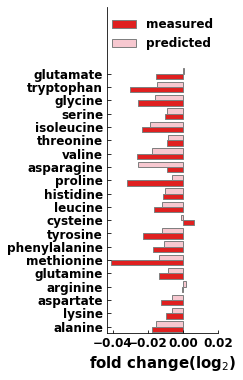

In [56]:
fig,ax=plt.subplots(figsize=(2,6))
ax=sns.barplot(y='aa', x='fold', hue='type', data=AAs, edgecolor=".5", 
               capsize=.1, linewidth=1, errwidth=1, palette=['red','pink'])
ax.set_ylim((-0.5,24))
#ax.spines['bottom'].set_position(('axes', 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False,loc='upper center')
#leg = ax.get_legend()
#new_labels = ['self '+ r'$\Delta$'+'(Z)', 'non self '+ r'$\Delta$'+'(Z)']
#for t, l in zip(leg.texts, new_labels):
#    t.set_text(l)
ax.set_ylabel('', fontsize=15, fontweight='bold')
ax.set_xlabel('fold change(log'+r'$_{2}$'+')', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', which='major', labelsize=12, direction='in')
ax.tick_params(axis='y', which='major', labelsize=12, direction='in')
ax.set_xticks([-0.04,-0.02,0,0.02])
#ax.set_xticklabels([1,2,3,4,5,6])
plt.xticks(weight = 'bold');
plt.yticks(weight = 'bold');

In [57]:
lc=['myristoylcarnitine (C14)',
'palmitoylcarnitine (C16)',
'margaroylcarnitine (C17)*',
'stearoylcarnitine (C18)',
'arachidoylcarnitine (C20)*',
'lignoceroylcarnitine (C24)*',
'cerotoylcarnitine (C26)*',
'myristoleate (14:1n5)',
'palmitoleate (16:1n7)',
'10-heptadecenoate (17:1n7)',
'oleate/vaccenate (18:1)',
'10-nonadecenoate (19:1n9)',
'eicosenoate (20:1)',
'erucate (22:1n9)',
'tetradecadienoate (14:2)*',
'stearidonate (18:4n3)',
'eicosapentaenoate (EPA; 20:5n3)',
'docosapentaenoate (n3 DPA; 22:5n3)',
'docosahexaenoate (DHA; 22:6n3)',
'docosatrienoate (22:3n3)',
'hexadecadienoate (16:2n6)',
'linoleate (18:2n6)',
'linolenate [alpha or gamma; (18:3n3 or 6)]',
'dihomo-linoleate (20:2n6)',
'dihomo-linolenate (20:3n3 or n6)',
'arachidonate (20:4n6)',
'docosatrienoate (22:3n6)*',
'adrenate (22:4n6)',
'docosapentaenoate (n6 DPA; 22:5n6)',
'docosadienoate (22:2n6)',
'mead acid (20:3n9)',
'myristate (14:0)',
'pentadecanoate (15:0)',
'palmitate (16:0)',
'margarate (17:0)',
'stearate (18:0)',
'nonadecanoate (19:0)',
'arachidate (20:0)'
]

In [58]:
LCs=pd.DataFrame(columns=['lc','type','fold'])
count=1
for i in sign.index[sign.index.isin(lc)]:
    LCs.loc[count,:]=[i,'measured',np.log2(sign.loc[i,'measured'])]
    count+=1
    LCs.loc[count,:]=[i,'predicted',np.log2(sign.loc[i,'predicted'])]
    count+=1


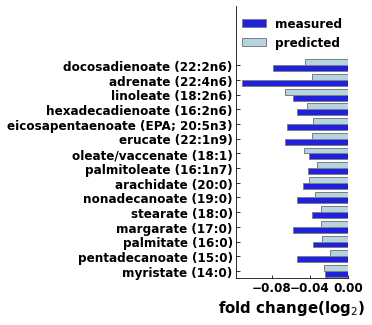

In [59]:
fig,ax=plt.subplots(figsize=(2,5))
ax=sns.barplot(y='lc', x='fold', hue='type', data=LCs, edgecolor=".5", 
               capsize=.1, linewidth=1, errwidth=1, palette=['blue','lightblue'])
ax.set_ylim((-0.5,18))
#ax.spines['bottom'].set_position(('axes', 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False,loc='upper center')
#leg = ax.get_legend()
#new_labels = ['self '+ r'$\Delta$'+'(Z)', 'non self '+ r'$\Delta$'+'(Z)']
#for t, l in zip(leg.texts, new_labels):
#    t.set_text(l)
ax.set_ylabel('', fontsize=15, fontweight='bold')
ax.set_xlabel('fold change(log'+r'$_{2}$'+')', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', which='major', labelsize=12, direction='in')
ax.tick_params(axis='y', which='major', labelsize=12, direction='in')
ax.set_xticks([-0.08,-0.04,0])
#ax.set_xticklabels([1,2,3,4,5,6])
plt.xticks(weight = 'bold');
plt.yticks(weight = 'bold');